In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
import sys
import matplotlib.pyplot as plt

In [3]:
sys.path.append('/home/mondzi259/Apna_Assignment/src/ml_auto/')

In [4]:
from custom_estimator import Estimator, scoring_metric
from encoding import FreqeuncyEncoding,TargetEncoding
from hyperopt_model_selection import HyperOptModelSelection,hp
from custom_fold_generator import KFold,GroupKFold,CustomFolds
from lightgbm import LGBMRegressor

In [5]:
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
DATA_DIR = '/home/mondzi259/Apna_Assignment/data/'

In [8]:
df = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=0)
df.shape

(30000, 19)

In [9]:
df.drop('feebackgiven',axis=1,inplace=True)

In [10]:
data_dic = pd.read_excel(os.path.join(DATA_DIR,'data.xlsx'),sheet_name=1,header=None)

In [11]:
data_dic

,0,1,2,3
0,lead,A candidate who has interacted with HR on the ...,NaN,NaN
1,shift,night/ day,"0 - day, 1 - night",NaN
2,gender,f/m/all,"0 - male jobs, 1 - female , 2 - all",NaN
3,education,10th to PG,"ordinally placed, 10th being lowest and PG the...",NaN
4,created_on,job created date,Days since a fixed reference data,"For ex: if reference data was 1 Jan 2020,\njob..."
5,employer_type,key-account/ smb/ enterprise/ consultant/ NA,"most jobs are smb, followed by Key accounts, e...",NaN
6,applicant_location,candidate distance from job,"lower the value, lower the distance requirement",NaN
7,city,city,is masked,NaN
8,area,area,is masked,NaN
9,organization,company name,is masked,NaN


In [12]:
df.head()

,shift,gender,education,created_on,dow,employer_type,applicant_location,city,area,organization,deposit,category,english,num_openings,max_salary,min_salary,is_part_time,leads_per_opening
0,0.0,0.0,3.0,413.0,3.0,0.0,0.0,1.0,4119.0,31278.0,0.0,55.0,2.0,22.0,21000.0,NaN,0.0,0.090909
1,0.0,0.0,3.0,529.0,0.0,4.0,0.0,2.0,2017.0,32006.0,0.0,54.0,2.0,2.0,80000.0,NaN,0.0,31.500000
2,0.0,0.0,0.0,457.0,0.0,4.0,0.0,3.0,1500.0,32029.0,0.0,42.0,3.0,1.0,3500.0,NaN,1.0,9.000000
3,0.0,0.0,4.0,450.0,3.0,4.0,0.0,5.0,638.0,9925.0,0.0,60.0,4.0,4.0,11500.0,NaN,0.0,0.000000
4,0.0,0.0,0.0,480.0,0.0,1.0,0.0,2.0,4115.0,8400.0,0.0,16.0,3.0,25.0,25000.0,NaN,0.0,1.400000


### Target vs created_on

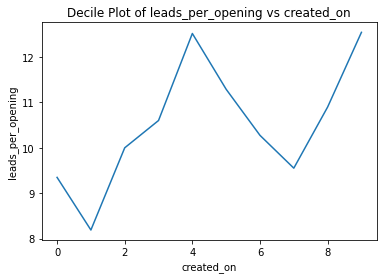

In [13]:
df.groupby(pd.qcut(df['created_on'],10,
                   duplicates='drop',labels=False))['leads_per_opening'].mean().plot()
plt.ylabel('leads_per_opening')
plt.title('Decile Plot of leads_per_opening vs created_on');

### 

In [14]:
num_cols = ['leads_per_opening','max_salary','min_salary','deposit','num_openings','created_on']
cat_cols = [i for i in df.columns.tolist() if i not in num_cols]
cat_ordinal_cols = ['applicant_location','english','education']
cat_non_ord_cols = [i for i in cat_cols if i not in cat_ordinal_cols]

In [15]:
cat_non_ord_cols,cat_ordinal_cols

(['shift',
  'gender',
  'dow',
  'employer_type',
  'city',
  'area',
  'organization',
  'category',
  'is_part_time'],
 ['applicant_location', 'english', 'education'])

In [16]:
df[cat_cols].nunique()

shift                     2
gender                    3
education                 6
dow                       7
employer_type             5
applicant_location        4
city                      7
area                   2740
organization          14886
category                 67
english                   4
is_part_time              2
dtype: int64

In [17]:
class FreqEnc:
    def __init__(self,cat_freq_cols):
        self.cat_freq_cols = cat_freq_cols
    def fit(self,df):
        self.freq_encoding_dict = {
                x: df[x].value_counts(1).to_dict() for x in self.cat_freq_cols
            }
    def transform(self,df):
        for col in self.cat_freq_cols:
            df[col+"_fe"] = df[col].map(self.freq_encoding_dict[col]).fillna(0)
        return df
    def fit_transform(self,df):
        self.fit(df)
        return self.transform(df)

In [18]:
df=df.sort_values('created_on').reset_index(drop=True)

In [19]:
df.shape

(30000, 18)

In [20]:
df['target'] = np.log1p(df.leads_per_opening)

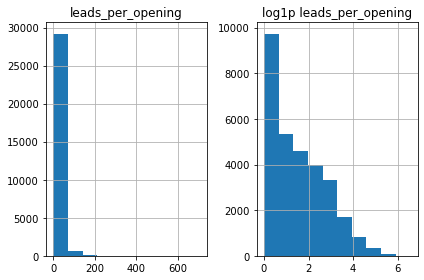

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
df.leads_per_opening.hist(ax=axes[0])
axes[0].set_title('leads_per_opening')
df.target.hist(ax=axes[1])
axes[1].set_title('log1p leads_per_opening')
plt.tight_layout()

In [22]:
df.target.describe()

count    30000.000000
mean         1.507317
std          1.264234
min          0.000000
25%          0.385158
50%          1.299283
75%          2.397895
max          6.559615
Name: target, dtype: float64

In [23]:
folds =[
    (df[(df.created_on<=df.created_on.quantile(0.7))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.7))&\
      (df.created_on<=df.created_on.quantile(0.8))].index.tolist()),
    
    (df[(df.created_on>=df.created_on.quantile(0.1))&\
      (df.created_on<=df.created_on.quantile(0.8))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.8))&\
      (df.created_on<=df.created_on.quantile(0.9))].index.tolist()),
    
    (df[(df.created_on>=df.created_on.quantile(0.2))&\
      (df.created_on<=df.created_on.quantile(0.9))].index.tolist(),\
df[(df.created_on>df.created_on.quantile(0.9))&\
      (df.created_on<=df.created_on.quantile(1))].index.tolist())
]

In [24]:
[(df.iloc[i].shape,df.iloc[j].shape) for i,j in folds]

[((21137, 19), (3031, 19)),
 ((21191, 19), (2865, 19)),
 ((21073, 19), (2967, 19))]

In [25]:
target = df.target.values

In [26]:
fe = FreqEnc(cat_freq_cols=cat_non_ord_cols)

df = fe.fit_transform(df)

In [27]:
(df['max_salary']-df.min_salary).describe()

count     4117.000000
mean      6104.805441
std       6419.603169
min      -2000.000000
25%       2000.000000
50%       5000.000000
75%       7500.000000
max      96399.000000
dtype: float64

In [28]:
df.shape

(30000, 28)

In [29]:
df[cat_non_ord_cols].nunique()

shift                2
gender               3
dow                  7
employer_type        5
city                 7
area              2740
organization     14886
category            67
is_part_time         2
dtype: int64

In [30]:
df[cat_ordinal_cols].nunique()

applicant_location    4
english               4
education             6
dtype: int64

### Adding cat-cat interactions

In [31]:
def get_derived_cat(df,a,b):
    df[a+'_'+b]= df[a].astype('str') + '_' + df[b].astype('str')
    return df 

In [32]:
def gen_cat_cat(df):
    df = get_derived_cat(df,'category','organization')
    df = get_derived_cat(df,'category','area')
    df = get_derived_cat(df,'category','city')
    df = get_derived_cat(df,'category','dow')
    df = get_derived_cat(df,'category','employer_type')
    
    df = get_derived_cat(df,'organization','area')
    df = get_derived_cat(df,'organization','city')
    df = get_derived_cat(df,'organization','dow')
    df = get_derived_cat(df,'organization','employer_type')
    
    df = get_derived_cat(df,'area','city')
    df = get_derived_cat(df,'area','dow')
    df = get_derived_cat(df,'area','employer_type')
    
    df = get_derived_cat(df,'city','dow')
    df = get_derived_cat(df,'city','employer_type')
    
    df = get_derived_cat(df,'dow','employer_type')
    
    df['cat_city_dow'] = df['category'].astype('str') + '_' + df['city'].astype('str') + '_' + df['dow'].astype('str')
    
    return df

In [33]:
df = gen_cat_cat(df)

In [34]:
cat_cat_cols = ['category_organization', 'category_area', 'category_city', 'category_dow',
                'category_employer_type', 'organization_area', 'organization_city', 'organization_dow', 
                'organization_employer_type', 'area_city', 'area_dow', 'area_employer_type', 'city_dow',
               'city_employer_type', 'dow_employer_type','cat_city_dow']

In [35]:
fe2 = FreqEnc(cat_freq_cols=['category_city'])

df = fe2.fit_transform(df)

In [36]:
class CatNumAgg:
    def __init__(self,agg_cols, agg_funcs, grpby_cols):
        self.agg_cols=agg_cols
        self.agg_funcs=agg_funcs
        self.grpby_cols=grpby_cols
    def fit(self,df):
        self.encoding_dict={}
        for grp_col in self.grpby_cols:
            agg_df = df.groupby(grp_col)[self.agg_cols].agg(self.agg_funcs).reset_index()
            agg_df.columns = [grp_col] + [
                i + "_" + j + "_grpby" + "_and_" + grp_col
                for i in self.agg_cols
                for j in self.agg_funcs
            ]
            self.encoding_dict[grp_col]=agg_df.to_dict()
    def transform(self,df):
        for k in self.encoding_dict:
            agg_df = pd.DataFrame(self.encoding_dict[k])
            df = df.merge(agg_df, on=k, how="left")
        return df
    def fit_transform(self,df):
        self.fit(df)
        return self.transform(df)

In [37]:
imp_num_cols = ['num_openings','max_salary','min_salary','education','applicant_location']
agg_funcs = ['mean','std','min','max','median']
cat_agg_cols = ['category','organization','area','category_city',
                'category_dow','city',
                'employer_type']

In [38]:
catnumagg = CatNumAgg(agg_cols= imp_num_cols,agg_funcs=agg_funcs, grpby_cols=cat_agg_cols)

In [39]:
df = catnumagg.fit_transform(df)

In [40]:
df.shape

(30000, 220)

In [41]:
imp_num_hist_cols = ['num_openings', 'max_salary', 'min_salary', 'education', 'applicant_location']

In [42]:
for i in imp_num_hist_cols:
    df[i+"_expanding_mean"]=df[i].expanding().mean().values
    df[i+"_expanding_std"]=df[i].expanding().std().values
    df[i+"_expanding_min"]=df[i].expanding().min().values
    df[i+"_expanding_median"]=df[i].expanding().median().values
    df[i+"_expanding_skew"]=df[i].expanding().skew().values
#     df[i+"_rolling_30_mean"] = p[i].rolling(30,min_periods=1).mean().values
    df[i+"_rolling_30_skew"] = df[i].rolling(30,min_periods=1).skew().values
    df[i+"_rolling_30_std"] = df[i].rolling(30,min_periods=1).std().values
#     df[i+"_rolling_15_mean"] = p[i].rolling(15,min_periods=1).mean().values
#     df[i+"_rolling_60_mean"] = p[i].rolling(60,min_periods=1).mean().values
#     df[i+"_rolling_30_median"] = p[i].rolling(30,min_periods=1).median().values
#     df[i+"_rolling_7_mean"] = p[i].rolling(7,min_periods=1).mean().values
    df[i+"_rolling_7_std"] = df[i].rolling(7,min_periods=1).std().values

In [43]:
uniq_cols = df.columns[df.nunique(dropna=False)==1]
len(uniq_cols)

20

In [44]:
df.drop(uniq_cols,axis=1,inplace=True)

In [46]:
remove_cols = cat_non_ord_cols + ['target','leads_per_opening'] + cat_cat_cols
use_cols = [i for i in df.columns if i not in remove_cols] 

In [47]:
params = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'min_child_samples': 120,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_leaves': 16,
 'objective': 'regression',
 'subsample': 0.8,
 'subsample_freq': 10}

In [48]:
est = Estimator(model=LGBMRegressor(**params),
               early_stopping_rounds=100,
               validation_scheme=folds,
               shuffle=True)

In [49]:
est.get_repeated_out_of_folds(df[use_cols].values,target)

[100]	valid_0's rmse: 0.900218	valid_0's l2: 0.810392	valid_1's rmse: 0.802491	valid_1's l2: 0.643992
[200]	valid_0's rmse: 0.895229	valid_0's l2: 0.801435	valid_1's rmse: 0.746781	valid_1's l2: 0.557682
[300]	valid_0's rmse: 0.895552	valid_0's l2: 0.802013	valid_1's rmse: 0.703224	valid_1's l2: 0.494524
[100]	valid_0's rmse: 0.843258	valid_0's l2: 0.711084	valid_1's rmse: 0.803446	valid_1's l2: 0.645525
[200]	valid_0's rmse: 0.83935	valid_0's l2: 0.704509	valid_1's rmse: 0.749132	valid_1's l2: 0.561199
[100]	valid_0's rmse: 0.873907	valid_0's l2: 0.763714	valid_1's rmse: 0.799869	valid_1's l2: 0.63979
[200]	valid_0's rmse: 0.872326	valid_0's l2: 0.760952	valid_1's rmse: 0.744197	valid_1's l2: 0.553829


{'cv_scores': [0.8941492951801739, 0.8359839072524916, 0.8706590032359921],
 'avg_cv_score': 0.866930735222886,
 'std_scores': 0.023891812753571832,
 'overall_cv_score': 1.714649443583569,
 'eval_score': 0.866930735222886}

In [50]:
feat_imps = est.feature_importances(columns = use_cols) 
feat_imps['cum_imp']=feat_imps.feature_importance.cumsum()
feat_imps

,column,feature_importance,rank,cum_imp
5,num_openings,0.041800,1,0.041800
6,max_salary,0.040837,2,0.082637
0,education,0.030606,3,0.113243
4,english,0.023194,4,0.136436
111,applicant_location_mean_grpby_and_category_city,0.017081,5,0.153517
42,num_openings_std_grpby_and_organization,0.015813,6,0.169330
38,applicant_location_mean_grpby_and_category,0.015292,7,0.184622
48,max_salary_min_grpby_and_organization,0.014955,8,0.199577
47,max_salary_std_grpby_and_organization,0.013500,9,0.213077
91,num_openings_mean_grpby_and_category_city,0.013302,10,0.226379


### Important variables that could be used for further feature engineering in order of importance

1. category,area, organization, city, dow
2. created_on, max_salary, num_openings, min_salary
3. education,english
4. employer type